In [1]:
import torch
torch.cuda.empty_cache()

import torchvision.transforms as transforms 

from utils import image_size, image_loader, view_image
from data_loader import load_split_data

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader = load_split_data('train')

transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.485],
        std =[0.229]),
    transforms.Resize(48)
    
])

t1w, t2w = image_loader(train_loader, 2)
t1w, t2w = image_size(t1w, 1), image_size(t2w, 2)
t1w, t2w = transform(t1w), transform(t2w)

In [2]:
import torch
import torch.nn as nn
from typing import List, Dict
from torchsummary import summary

class CnvMod(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size = (5, 5)):
        super(CnvMod, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 
                        kernel_size = (1, 1), bias = False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace = True)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

class EncMod(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(EncMod, self).__init__()
        self.block = nn.Sequential(
            CnvMod(input_channel, output_channel, kernel_size = (3, 3)),
            nn.MaxPool2d(1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

class DecMod(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(DecMod, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel,
                                kernel_size = (2, 2), bias = False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        return self.block(x)

class Map(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(Map, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 
                        kernel_size = (4, 4)),
            nn.LogSigmoid()
        )
    def forward(self, x):
        return self.block(x)

In [4]:
class EncoderTrack(nn.Module):
    def __init__(self):
        super(EncoderTrack, self).__init__()
        self.encodermodules = nn.ModuleList([
            EncMod(1 if i == 0 else 2 ** (i + 1), 2 ** (i + 2)) for i in range(0, 5)
        ])
        self.decodermodule = DecMod(64, 64)
        self.encodermodule = EncMod(64, 128)

    def encoder_track(self, x):
        for encoder in self.encodermodules:
            x = encoder(x)
        return self.encodermodule(self.decodermodule(x))
    
    def forward(self, a, b):
        return torch.concat((self.encoder_track(a), self.encoder_track(b)))

class EncoderSubTrackA(nn.Module):
    def __init__(self):
        super(EncoderSubTrackA, self).__init__()
        self.encodermodules = nn.ModuleList([
            EncMod(1 if i == 0 else 2 ** (i + 1), 2 ** (i + 2)) for i in range(0, 1) 
        ])
    def encoder_track(self, x):
        for encoder in self.encodermodules:
            x = encoder(x)
        return x
    def forward(self, a, b):
        return torch.concat((self.encoder_track(a), self.encoder_track(b)))

class EncoderSubTrackB(nn.Module):
    def __init__(self):
        super(EncoderSubTrackB, self).__init__()
        self.encodermodules = nn.ModuleList([
            EncMod(1 if i == 0 else 2 ** (i + 1), 2 ** (i + 2)) for i in range(0, 2) 
        ])
    def encoder_track(self, x):
        for encoder in self.encodermodules:
            x = encoder(x)
        return x
    def forward(self, a, b):
        return torch.concat((self.encoder_track(a), self.encoder_track(b)))

class EncoderSubTrackC(nn.Module):
    def __init__(self):
        super(EncoderSubTrackC, self).__init__()
        self.encodermodules = nn.ModuleList([
            EncMod(1 if i == 0 else 2 ** (i + 1), 2 ** (i + 2)) for i in range(0, 3) 
        ])
    def encoder_track(self, x):
        for encoder in self.encodermodules:
            x = encoder(x)
        return x
    def forward(self, a, b):
        return torch.concat((self.encoder_track(a), self.encoder_track(b)))

class EncoderSubTrackD(nn.Module):
    def __init__(self):
        super(EncoderSubTrackD, self).__init__()
        self.encodermodules = nn.ModuleList([
            EncMod(1 if i == 0 else 2 ** (i + 1), 2 ** (i + 2)) for i in range(0, 4) 
        ])
    def encoder_track(self, x):
        for encoder in self.encodermodules:
            x = encoder(x)
        return x
    def forward(self, a, b):
        return torch.concat((self.encoder_track(a), self.encoder_track(b)))

class DecoderTrack(nn.Module):
    def __init__(self):
        super(DecoderTrack, self).__init__()
        self.convmodules = nn.ModuleList([ 
            CnvMod(2 ** (i + 2), 2 ** (i + 2)) for i in range(5, 0, -1)
            ])
        self.decodermodules = nn.ModuleList([ 
            DecMod(2 ** (i + 2), 2 ** (i + 1)) for i in range(5, 0, -1)
            ])
        self.map = nn.ModuleList([ 
            Map(2 ** (i + 1), 2 ** (i + 2)) for i in range(5, 0, -1)
            ])

    def forward(self, x):
        for cnv, dec, mp in zip(self.convmodules, self.decodermodules, self.map):
            x = mp(dec(cnv(x)))
        return x

class DecoderTrackA(nn.Module):
    def __init__(self):
        super(DecoderTrackA, self).__init__()
        self.convmodules = CnvMod(128, 128)
        self.decodermodules = DecMod(128, 64)
        self.map = Map(64, 32)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

class DecoderTrackB(nn.Module):
    def __init__(self):
        super(DecoderTrackB, self).__init__()
        self.convmodules = CnvMod(32, 64)
        self.decodermodules = DecMod(64, 32)
        self.map = Map(32, 16)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

class DecoderTrackC(nn.Module):
    def __init__(self):
        super(DecoderTrackC, self).__init__()
        self.convmodules = CnvMod(16, 32)
        self.decodermodules = DecMod(32, 16)
        self.map = Map(16, 8)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

class DecoderTrackD(nn.Module):
    def __init__(self):
        super(DecoderTrackD, self).__init__()
        self.convmodules = CnvMod(8, 16)
        self.decodermodules = DecMod(16, 8)
        self.map = Map(8, 4)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

class DecoderTrackE(nn.Module):
    def __init__(self):
        super(DecoderTrackE, self).__init__()
        self.convmodules = CnvMod(4, 8)
        self.decodermodules = DecMod(8, 4)
        self.map = Map(4, 2)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))
        
class CondNet(nn.Module):
    def __init__(self):
        super(CondNet, self).__init__()
        self.encoder = EncoderTrack()

    def forward(self, a, b):
        x = self.encoder(a, b)
                                 
        return x

#summary(CondNet(), (1, 48, 48), device = 'cuda')

In [5]:
model = CondNet().to('cpu')
output = model(t1w, t1w)

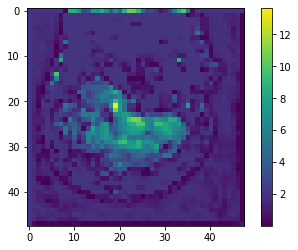

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.485],
        std =[0.229]),
    transforms.Resize((48))
])
# out = transform(output)
out = transform(output)
out = out.permute(2, 3, 0, 1).detach().numpy()
plt.imshow(np.abs(out[:, :, 100, 0]))
plt.colorbar()

In [7]:
class Cond1(nn.Module):
    def __init__(self):
        super(Cond1, self).__init__()
        self.sub_encoderD = EncoderSubTrackD()
        self.sub_encoderC = EncoderSubTrackC()
        self.sub_encoderB = EncoderSubTrackB()
        self.sub_encoderA = EncoderSubTrackA()

    def forward(self, a, b):
        skipA = self.sub_encoderD(a, b)      
        skipB = self.sub_encoderC(a, b)     
        skipC = self.sub_encoderB(a, b)      
        skipD = self.sub_encoderA(a, b)        
                                                  
 
        return skipA, skipB, skipC, skipD

model1 = Cond1()
encoderA, encoderB, encoderC, encoderD = model1(t1w, t1w)

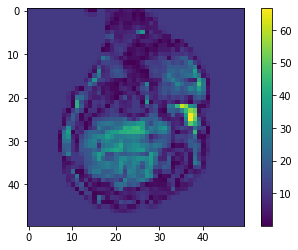

In [23]:
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.Normalize(
        mean=[0.485],
        std =[0.229]),
    transforms.Resize((50))
])

encA = transform(concatE)
encA = transform(encA).permute(2, 3, 0, 1).detach().numpy()
plt.imshow(np.abs(encA[:, :, 140, 0]))
plt.colorbar()

In [10]:
class DecoderTrackA(nn.Module):
    def __init__(self):
        super(DecoderTrackA, self).__init__()
        self.convmodules = CnvMod(128, 128)
        self.decodermodules = DecMod(128, 64)
        self.map = Map(64, 32)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

decoderA = DecoderTrackA()
decA = decoderA(output)

In [11]:
concatB = torch.concat((encoderA[:, :, :47, :47], encoderA[:, :, :47, :47], decA))

In [12]:
class DecoderTrackB(nn.Module):
    def __init__(self):
        super(DecoderTrackB, self).__init__()
        self.convmodules = CnvMod(32, 64)
        self.decodermodules = DecMod(64, 32)
        self.map = Map(32, 16)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

decoderB = DecoderTrackB()
decB = decoderB(concatB)

In [13]:
concatC = torch.concat((encoderB[:, :, :45, :45], encoderB[:, :, :45, :45], decB))

In [14]:
class DecoderTrackC(nn.Module):
    def __init__(self):
        super(DecoderTrackC, self).__init__()
        self.convmodules = CnvMod(16, 32)
        self.decodermodules = DecMod(32, 16)
        self.map = Map(16, 8)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

decoderC = DecoderTrackC()
decC = decoderC(concatC)

In [15]:
concatD = torch.concat((encoderC[:, :, :43, :43], encoderC[:, :, :43, :43], decC))

In [16]:
class DecoderTrackD(nn.Module):
    def __init__(self):
        super(DecoderTrackD, self).__init__()
        self.convmodules = CnvMod(8, 16)
        self.decodermodules = DecMod(16, 8)
        self.map = Map(8, 4)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

decoderD = DecoderTrackD()
decD = decoderD(concatD)

In [17]:
concatE = torch.concat((encoderD[:, :, :41, :41], encoderD[:, :, :41, :41], decD))

In [18]:
class DecoderTrackE(nn.Module):
    def __init__(self):
        super(DecoderTrackE, self).__init__()
        self.convmodules = CnvMod(4, 8)
        self.decodermodules = DecMod(8, 4)
        self.map = Map(4, 1)

    def forward(self, x):
        return self.map(self.decodermodules(self.convmodules(x)))

decoderE = DecoderTrackE()
decE = decoderE(concatE)